In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции 𝑦=𝑠𝑖𝑛(𝑥)𝑥−𝑥10. При выполненинии данного задания структура GAN остается той же, но Вам нужно:

    Сгенерировать настоящие данные
    Изменить архитектуру дискриминатора и генератора
    Без графиков домашку не принимаю


In [3]:
def func_y(x):
    return np.sin(x)/x - x/10

train_data_x = np.linspace(-1,1,2048)
np.delete(train_data_x, 0)
train_data_y = func_y(train_data_x)
train_data = list(zip(train_data_x, train_data_y))
train_data = torch.tensor(train_data)

In [4]:
#train_labels = torch.ones(len(train_data))

In [5]:
#train_set = [(train_data[i], train_labels[i]) for i in range(len(train_data))]

In [14]:
n_epochs = 200
batch_size = 32
lr = 0.0002

b1 = 0.5
b2 = 0.999

In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(8, 64),
            #*block(128, 256),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        return self.model(x)

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(0.2))
            return layers
        
        self.model = nn.Sequential(
            *block(2, 128),
            #*block(256, 128),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, x):
        return self.model(x)

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [19]:
d_loss_history = []
g_loss_history = []

[Epoch 119/120] [Batch 42/2048] [D loss: 0.692449] [G loss: 0.696718]


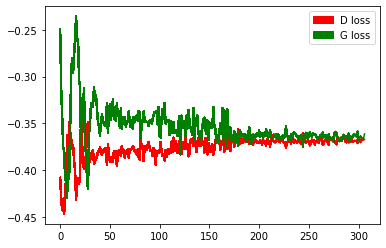

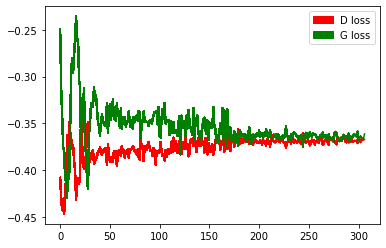

In [20]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

sample_interval = 25

for epoch in range(n_epochs):
    for i, (data) in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)  
        
        real_data = data.type(torch.FloatTensor).to(device)
######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 8))).to(device)

        generator_data = generator(noise)

        validity = discriminator(generator_data)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_data)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(generator_data.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            
            
#             display.clear_output(wait=False)
#             sample_image(gen_imgs)
            

            
#             display.display(plt.gcf())
                        
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)
            
            display.clear_output(wait=False)
            #plt.clf()
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_data), d_loss.item(), g_loss.item()) ) 
            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            
            display.display(plt.gcf())
            #plt.show()

            

In [35]:
noise = torch.FloatTensor(np.random.normal(0, 1, (1000, 8))).to(device)
generated_data = generator(noise)
generated_data = generated_data.detach()

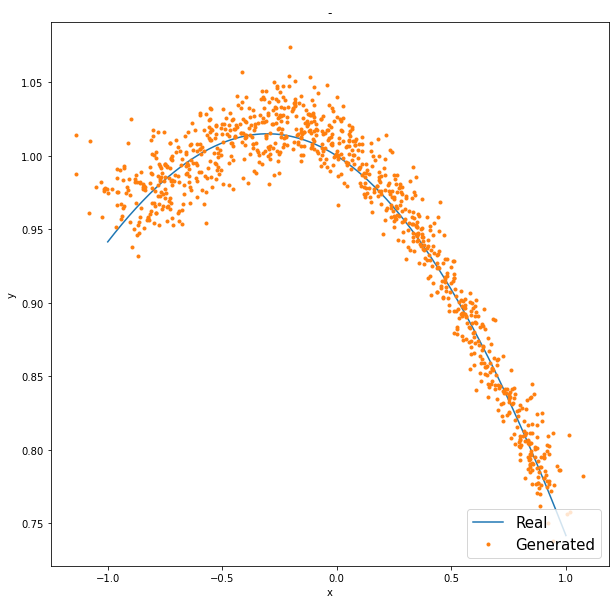

In [36]:
fig = plt.figure(figsize=(10, 10))

#------------------------------------------------------------------------------
#
plt.plot(train_data[:, 0], train_data[:, 1], label='Real')
plt.plot(generated_data[:, 0], generated_data[:, 1], '.', label='Generated')

plt.xlabel('x')
plt.ylabel('y')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()
#------------------------------------------------------------------------------

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [37]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [38]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [46]:
img_shape

(1, 28, 28)

In [186]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
    
generator = Generator().to(device)

print(generator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)


In [189]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Upsampling
        self.down = nn.Sequential(nn.Conv2d(channels, 64, 3, 2, 1), 
                                  nn.ReLU())
        # Fully-connected layers
        self.down_size = img_size // 2
        down_dim = 64 * (img_size // 2) ** 2
        self.fc = nn.Sequential(
            nn.Linear(down_dim, 32),
            nn.BatchNorm1d(32, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(32, down_dim),
            nn.BatchNorm1d(down_dim),
            nn.ReLU(inplace=True),
        )
        # Upsampling
        self.up = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(64, channels, 3, 1, 1))

    def forward(self, img):
        out = self.down(img)
        out = self.fc(out.view(out.size(0), -1))
        out = self.up(out.view(out.size(0), 64, self.down_size, self.down_size))
        return out
    
    
discriminator = Discriminator().to(device)
    
print(discriminator)

Discriminator(
  (down): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=32, out_features=12544, bias=True)
    (4): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (up): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [190]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

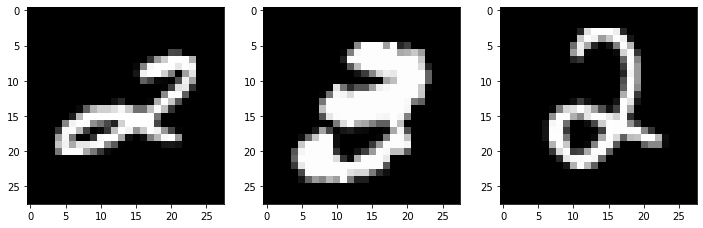

In [191]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [192]:
#generator = Generator().to(device)
#discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [193]:
d_loss_history = []
g_loss_history = []

In [194]:
real_cpu = imgs[0].to(device)
b_size = real_cpu.size(0)

In [195]:
real_cpu.shape

torch.Size([1, 28, 28])

In [224]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

k = 0
f = 0

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
        
        real_cpu = imgs[0].to(device)
        b_size = real_cpu.size(0)
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        #z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))).to(device)

        gen_imgs = generator(z)

        #validity = discriminator(gen_imgs.detach())
        g_loss = torch.mean(torch.abs(discriminator(gen_imgs) - gen_imgs))
        #g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        #d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs)
        #d_fake_loss = adversarial_loss(fake_pred, fake)
        
        d_real_loss = torch.mean(torch.abs(real_pred - real_imgs))
        d_fake_loss = torch.mean(torch.abs(fake_pred - gen_imgs.detach()))

        d_loss = (d_real_loss + d_fake_loss) / 2
        #d_loss = d_real_loss - k * d_fake_loss
        
        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
#             plt.clf()
            #print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 
            display.clear_output(wait=False)
            #sample_image(gen_imgs)           
    
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
#             plt.show()
            display.display(plt.gcf())

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [226]:
z.shape

torch.Size([64, 100])

In [227]:
gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [214]:
d_fake_loss

tensor(0.1790, grad_fn=<MeanBackward0>)